In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, labels=next_states_labels)
    eloss = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1))
    eloss_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    eloss += -tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # maximize loss
    aloss2_ = tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, labels=next_states_labels)
    aloss2 = tf.reduce_mean(tf.reduce_sum(eloss_, axis=1)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    #rewards__ = tf.square(e_next_states_logits - next_states) 
    next_states_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                               labels=next_states_labels)
    rewards_in = tf.reduce_mean(tf.reduce_sum(next_states_loss, axis=1))
    targetQs = rewards_in + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2, rewards_in

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2, self.rewards_in = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            rewards_in = sess.run(model.rewards_in, feed_dict)
            aloss2, _ = sess.run([model.a_loss2, model.a_opt2], feed_dict)
            #print('rewards_in.mean():', rewards_in.mean())
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.7209 eloss:13.0488 aloss2:3.5452 exploreP:0.9984
Episode:1 meanR:23.0000 R:30.0000 rate:0.0600 aloss:0.7020 eloss:13.2271 aloss2:3.4731 exploreP:0.9955
Episode:2 meanR:22.0000 R:20.0000 rate:0.0400 aloss:0.6979 eloss:13.2501 aloss2:3.4519 exploreP:0.9935
Episode:3 meanR:22.0000 R:22.0000 rate:0.0440 aloss:0.6861 eloss:13.1282 aloss2:3.4249 exploreP:0.9913
Episode:4 meanR:22.4000 R:24.0000 rate:0.0480 aloss:0.7263 eloss:13.0627 aloss2:3.4919 exploreP:0.9890
Episode:5 meanR:21.0000 R:14.0000 rate:0.0280 aloss:0.6836 eloss:13.2919 aloss2:3.3802 exploreP:0.9876
Episode:6 meanR:20.7143 R:19.0000 rate:0.0380 aloss:0.6863 eloss:13.1874 aloss2:3.4182 exploreP:0.9857
Episode:7 meanR:19.7500 R:13.0000 rate:0.0260 aloss:0.6864 eloss:13.0140 aloss2:3.4418 exploreP:0.9845
Episode:8 meanR:19.6667 R:19.0000 rate:0.0380 aloss:0.6841 eloss:12.8620 aloss2:3.4372 exploreP:0.9826
Episode:9 meanR:19.2000 R:15.0000 rate:0.0300 aloss:0.6920 eloss:12.9628 

Episode:80 meanR:24.7531 R:19.0000 rate:0.0380 aloss:0.7054 eloss:5.8123 aloss2:4.5302 exploreP:0.8201
Episode:81 meanR:24.6220 R:14.0000 rate:0.0280 aloss:0.7539 eloss:5.8983 aloss2:4.6340 exploreP:0.8190
Episode:82 meanR:24.7349 R:34.0000 rate:0.0680 aloss:0.7518 eloss:5.7904 aloss2:4.5943 exploreP:0.8163
Episode:83 meanR:24.7143 R:23.0000 rate:0.0460 aloss:0.7386 eloss:5.8503 aloss2:4.5898 exploreP:0.8144
Episode:84 meanR:25.0706 R:55.0000 rate:0.1100 aloss:0.7336 eloss:5.9303 aloss2:4.5547 exploreP:0.8100
Episode:85 meanR:24.9884 R:18.0000 rate:0.0360 aloss:0.7267 eloss:5.9703 aloss2:4.5123 exploreP:0.8086
Episode:86 meanR:24.8161 R:10.0000 rate:0.0200 aloss:0.7297 eloss:5.9835 aloss2:4.5167 exploreP:0.8078
Episode:87 meanR:24.7500 R:19.0000 rate:0.0380 aloss:0.7319 eloss:6.0645 aloss2:4.5290 exploreP:0.8062
Episode:88 meanR:24.6629 R:17.0000 rate:0.0340 aloss:0.6908 eloss:6.1033 aloss2:4.4694 exploreP:0.8049
Episode:89 meanR:24.7222 R:30.0000 rate:0.0600 aloss:0.7154 eloss:6.1793 

Episode:159 meanR:29.8300 R:42.0000 rate:0.0840 aloss:0.7113 eloss:6.9462 aloss2:4.8714 exploreP:0.6440
Episode:160 meanR:30.0200 R:34.0000 rate:0.0680 aloss:0.6798 eloss:7.1096 aloss2:4.8404 exploreP:0.6419
Episode:161 meanR:30.5000 R:64.0000 rate:0.1280 aloss:0.6864 eloss:7.2435 aloss2:4.8279 exploreP:0.6379
Episode:162 meanR:30.7000 R:59.0000 rate:0.1180 aloss:0.7061 eloss:7.4967 aloss2:4.8610 exploreP:0.6342
Episode:163 meanR:30.8100 R:26.0000 rate:0.0520 aloss:0.6929 eloss:7.6496 aloss2:4.8079 exploreP:0.6325
Episode:164 meanR:30.9400 R:32.0000 rate:0.0640 aloss:0.6947 eloss:7.6606 aloss2:4.8149 exploreP:0.6305
Episode:165 meanR:31.0300 R:29.0000 rate:0.0580 aloss:0.6998 eloss:7.7442 aloss2:4.7643 exploreP:0.6288
Episode:166 meanR:31.2700 R:68.0000 rate:0.1360 aloss:0.7036 eloss:7.6278 aloss2:4.7928 exploreP:0.6246
Episode:167 meanR:31.3600 R:23.0000 rate:0.0460 aloss:0.7176 eloss:7.6631 aloss2:4.7814 exploreP:0.6231
Episode:168 meanR:31.4100 R:27.0000 rate:0.0540 aloss:0.7024 elo

Episode:238 meanR:45.4900 R:107.0000 rate:0.2140 aloss:0.6797 eloss:6.5735 aloss2:6.6333 exploreP:0.4434
Episode:239 meanR:46.7300 R:200.0000 rate:0.4000 aloss:0.6903 eloss:6.7531 aloss2:6.6528 exploreP:0.4348
Episode:240 meanR:47.4500 R:98.0000 rate:0.1960 aloss:0.6851 eloss:6.6663 aloss2:6.6920 exploreP:0.4307
Episode:241 meanR:48.2000 R:91.0000 rate:0.1820 aloss:0.6831 eloss:6.6508 aloss2:6.7637 exploreP:0.4268
Episode:242 meanR:48.6300 R:70.0000 rate:0.1400 aloss:0.6843 eloss:6.6794 aloss2:6.7770 exploreP:0.4239
Episode:243 meanR:51.0400 R:261.0000 rate:0.5220 aloss:0.6943 eloss:6.7351 aloss2:6.7906 exploreP:0.4133
Episode:244 meanR:52.7400 R:208.0000 rate:0.4160 aloss:0.6989 eloss:6.6825 aloss2:6.8894 exploreP:0.4050
Episode:245 meanR:53.7200 R:137.0000 rate:0.2740 aloss:0.6949 eloss:6.7174 aloss2:6.9782 exploreP:0.3996
Episode:246 meanR:58.2400 R:500.0000 rate:1.0000 aloss:0.7018 eloss:6.7664 aloss2:7.1134 exploreP:0.3806
Episode:247 meanR:59.2600 R:134.0000 rate:0.2680 aloss:0.7

Episode:316 meanR:250.5600 R:500.0000 rate:1.0000 aloss:0.6564 eloss:5.4309 aloss2:10.2141 exploreP:0.0513
Episode:317 meanR:255.3000 R:500.0000 rate:1.0000 aloss:0.6541 eloss:5.4709 aloss2:10.4426 exploreP:0.0493
Episode:318 meanR:259.9600 R:500.0000 rate:1.0000 aloss:0.6457 eloss:5.4325 aloss2:10.5035 exploreP:0.0474
Episode:319 meanR:264.6700 R:500.0000 rate:1.0000 aloss:0.6494 eloss:5.4733 aloss2:10.5742 exploreP:0.0456
Episode:320 meanR:269.4100 R:500.0000 rate:1.0000 aloss:0.6573 eloss:5.3006 aloss2:10.9345 exploreP:0.0438
Episode:321 meanR:274.0800 R:500.0000 rate:1.0000 aloss:0.6509 eloss:5.2966 aloss2:10.9820 exploreP:0.0422
Episode:322 meanR:278.4000 R:500.0000 rate:1.0000 aloss:0.6559 eloss:5.2084 aloss2:11.2606 exploreP:0.0406
Episode:323 meanR:283.2200 R:500.0000 rate:1.0000 aloss:0.6430 eloss:5.4054 aloss2:11.4519 exploreP:0.0391
Episode:324 meanR:287.2900 R:500.0000 rate:1.0000 aloss:0.6469 eloss:5.2384 aloss2:11.6398 exploreP:0.0377
Episode:325 meanR:291.7000 R:500.0000

Episode:393 meanR:487.2700 R:500.0000 rate:1.0000 aloss:0.5298 eloss:6.5787 aloss2:14.4237 exploreP:0.0109
Episode:394 meanR:487.5700 R:500.0000 rate:1.0000 aloss:0.5342 eloss:6.3697 aloss2:14.3925 exploreP:0.0109
Episode:395 meanR:489.1100 R:500.0000 rate:1.0000 aloss:0.5352 eloss:6.4447 aloss2:14.3144 exploreP:0.0108
Episode:396 meanR:492.6700 R:500.0000 rate:1.0000 aloss:0.5380 eloss:6.3722 aloss2:14.2490 exploreP:0.0108
Episode:397 meanR:492.6700 R:500.0000 rate:1.0000 aloss:0.5341 eloss:6.3374 aloss2:14.3962 exploreP:0.0107
Episode:398 meanR:495.1600 R:500.0000 rate:1.0000 aloss:0.5134 eloss:6.7322 aloss2:14.2882 exploreP:0.0107
Episode:399 meanR:495.1600 R:500.0000 rate:1.0000 aloss:0.5316 eloss:6.3928 aloss2:14.0750 exploreP:0.0107
Episode:400 meanR:495.1600 R:500.0000 rate:1.0000 aloss:0.5301 eloss:6.4530 aloss2:14.0142 exploreP:0.0106
Episode:401 meanR:495.1600 R:500.0000 rate:1.0000 aloss:0.5227 eloss:6.5008 aloss2:14.0184 exploreP:0.0106
Episode:402 meanR:496.6300 R:500.0000

Episode:470 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4230 eloss:7.2031 aloss2:9.6399 exploreP:0.0100
Episode:471 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4183 eloss:7.2240 aloss2:9.5864 exploreP:0.0100
Episode:472 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4229 eloss:7.1853 aloss2:9.6044 exploreP:0.0100
Episode:473 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4186 eloss:7.2024 aloss2:9.5583 exploreP:0.0100
Episode:474 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4150 eloss:7.1845 aloss2:9.5169 exploreP:0.0100
Episode:475 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4154 eloss:7.1907 aloss2:9.5559 exploreP:0.0100
Episode:476 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4158 eloss:7.2073 aloss2:9.4809 exploreP:0.0100
Episode:477 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4139 eloss:7.1866 aloss2:9.5274 exploreP:0.0100
Episode:478 meanR:498.5800 R:500.0000 rate:1.0000 aloss:0.4146 eloss:7.1682 aloss2:9.5167 exploreP:0.0100
Episode:479 meanR:498.5800 R:500.0000 rate:1.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

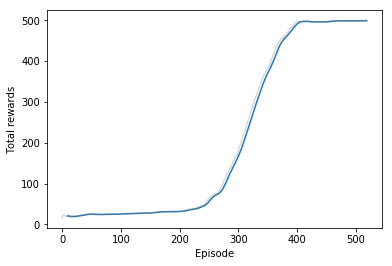

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

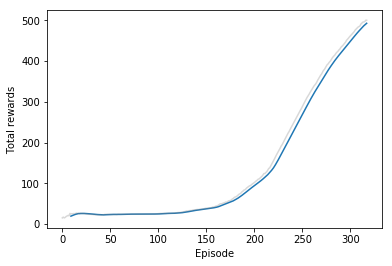

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

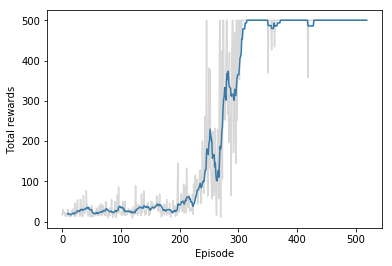

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

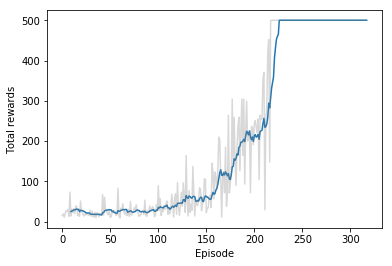

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

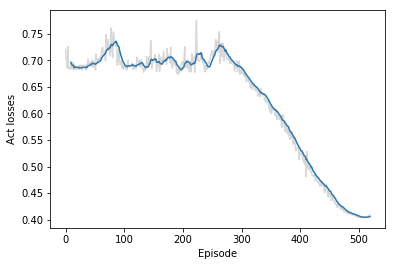

In [19]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Act losses')

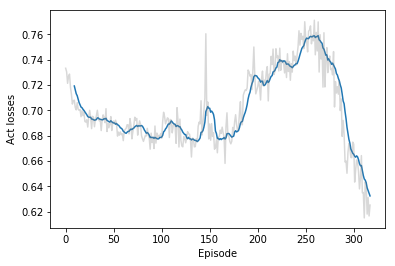

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

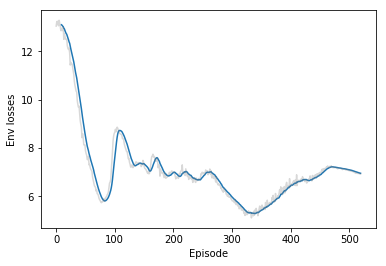

In [20]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Env losses')

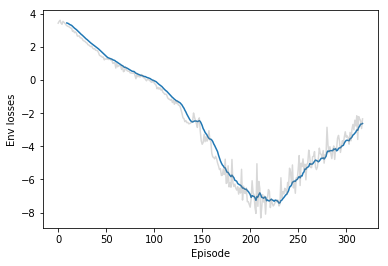

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

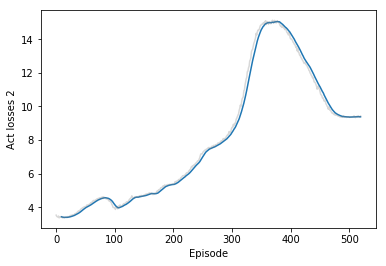

In [21]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

Text(0, 0.5, 'Act losses 2')

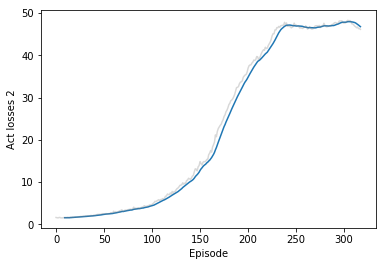

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
